In [1]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
import random

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex

pyro.enable_validation(True)

In [2]:
# generating simulated data
def generate_data(group):
    #diagonal group
    if group == 'diag':
        dat = dist.Dirichlet(torch.tensor([[5.,1.,1.,1.,1.],
                                           [1.,5.,1.,1.,1.],
                                            [1.,1.,5.,1.,1.],
                                            [1.,1.,1.,5.,1.],
                                            [1.,1.,1.,1.,5.],
                                            [1.,1.,1.,1.,5.],
                                            [1.,1.,1.,5.,1.],
                                            [1.,1.,5.,1.,1.],
                                            [1.,5.,1.,1.,1.],
                                            [5.,1.,1.,1.,1.],
                                            [5.,1.,1.,1.,1.],
                                            [1.,5.,1.,1.,1.],
                                            [1.,1.,5.,1.,1.],
                                            [1.,1.,1.,5.,1.],
                                            [1.,1.,1.,1.,5.]])).sample()
    # one side group
    elif group == 'side':
        dat = dist.Dirichlet(torch.tensor([[5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [1.,1.,1.,1.,5.],
                                           [1.,1.,1.,1.,5.],
                                           [1.,1.,1.,1.,5.],
                                           [1.,1.,1.,1.,5.],
                                           [1.,1.,1.,1.,5.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.],
                                           [5.,1.,1.,1.,1.]])).sample()
    return dat
    


random.seed(680814)
data = torch.stack([generate_data('diag') for i in range(100)] +
                   [generate_data('side') for i in range(100)],dim=0)
#print(data)
print(data.shape)
# data = data.permute([2,1,0])
# print(data.shape)

torch.Size([200, 15, 5])


In [7]:
K = 2  # Fixed number of components.

@config_enumerate()
def model(data):
    # Background probability of different groups (assume equally likely)
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
#    scale = pyro.sample('scale', dist.LogNormal(torch.zeros(4), 2. * torch.ones(4)).to_event(1))
    with pyro.plate('components', K):
        # concentration parameters
        concentration = pyro.sample('concentration', dist.Gamma(2 * torch.ones(15,5), 1/3 * torch.ones(15,5)).to_event(2))
#         print(concentration.dtype)
        
    with pyro.plate('data', data.shape[0]):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        #d = dist.Dirichlet(concentration[assignment,:,:].clone().detach()) # .detach() might interfere with backprop
        d = dist.Dirichlet(concentration[assignment,:,:])
        #print(d.to_event(1).batch_shape, d.to_event(1).event_shape)

        pyro.sample('obs', d.to_event(1), obs=data)

In [8]:
model(data)

In [9]:
# K = 2  # Fixed number of components.

# @config_enumerate()
# def model(data):
#     # Background probability of different groups (assume equally likely)
#     weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
# #    scale = pyro.sample('scale', dist.LogNormal(torch.zeros(4), 2. * torch.ones(4)).to_event(1))
#     with pyro.plate('components', K):
#         # concentration parameters
#         concentration1 = pyro.sample('concentration1', dist.Gamma(2 * torch.ones(15), 1/3 * torch.ones(15)).to_event(1))
#         concentration2 = pyro.sample('concentration2', dist.Gamma(2 * torch.ones(15), 1/3 * torch.ones(15)).to_event(1))
#         concentration3 = pyro.sample('concentration3', dist.Gamma(2 * torch.ones(15), 1/3 * torch.ones(15)).to_event(1))
#         concentration4 = pyro.sample('concentration4', dist.Gamma(2 * torch.ones(15), 1/3 * torch.ones(15)).to_event(1))
#         concentration5 = pyro.sample('concentration5', dist.Gamma(2 * torch.ones(15), 1/3 * torch.ones(15)).to_event(1))
#         print('concentration: ',concentration1.shape)
        
#     with pyro.plate('data', data.shape[0]):
#         # Local variables.
#         assignment = pyro.sample('assignment', dist.Categorical(weights))
# #         print('assignment', assignment)
# #         print('indexed by assignment',concentration1[assignment])
#         d = dist.Dirichlet(torch.stack([concentration1[assignment,:],
#                                          concentration2[assignment,:],
#                                          concentration3[assignment,:],
#                                          concentration4[assignment,:],
#                                          concentration5[assignment,:]],dim = 2))

#         #d = dist.Beta(alphas[assignment,:], betas[assignment,:]) # this works just as well
#         pyro.sample('obs', d.to_event(1), obs=data)
        

In [10]:
# # still wrong
# K = 2  # Fixed number of components.

# @config_enumerate()
# def model(data):
#     # Background probability of different groups (assume equally likely)
#     weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
# #    scale = pyro.sample('scale', dist.LogNormal(torch.zeros(4), 2. * torch.ones(4)).to_event(1))
#     with pyro.plate('components', K):
#         # concentration parameters
#         concentration1 = pyro.sample('concentration1', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration2 = pyro.sample('concentration2', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration3 = pyro.sample('concentration3', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration4 = pyro.sample('concentration4', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration5 = pyro.sample('concentration5', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration6 = pyro.sample('concentration6', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration7 = pyro.sample('concentration7', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration8 = pyro.sample('concentration8', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration9 = pyro.sample('concentration9', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration10 = pyro.sample('concentration10', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration11 = pyro.sample('concentration11', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration12 = pyro.sample('concentration12', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration13 = pyro.sample('concentration13', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration14 = pyro.sample('concentration14', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         concentration15 = pyro.sample('concentration15', dist.Gamma(2 * torch.ones(5), 1/3 * torch.ones(5)).to_event(1))
#         print('concentration: ',concentration1)
        
#     with pyro.plate('data', data.shape[0]):
#         # Local variables.
#         assignment = pyro.sample('assignment', dist.Categorical(weights))
# #         print('assignment', assignment)
# #         print('indexed by assignment',concentration1[assignment])
# #         print(torch.stack([concentration1[assignment],concentration2[assignment]],dim = 1))
#         d = dist.Dirichlet(torch.stack([concentration1[assignment,:],
#                                          concentration2[assignment,:],
#                                          concentration3[assignment,:],
#                                          concentration4[assignment,:],
#                                          concentration5[assignment,:],
#                                          concentration6[assignment,:],
#                                          concentration7[assignment,:],
#                                          concentration8[assignment,:],
#                                          concentration9[assignment,:],
#                                          concentration10[assignment,:],
#                                          concentration11[assignment,:],
#                                          concentration12[assignment,:],
#                                          concentration13[assignment,:],
#                                          concentration14[assignment,:],
#                                          concentration15[assignment,:]],dim = 1))

#         #d = dist.Beta(alphas[assignment,:], betas[assignment,:]) # this works just as well
#         pyro.sample('obs', d.to_event(1), obs=data)
        

In [11]:
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

def initialize(seed):           
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'concentration']))
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

loss, seed = min((initialize(seed), seed) for seed in range(100))
#initialize(100)
print('seed = {}, initial_loss = {}'.format(seed, loss))


seed = 76, initial_loss = 19360.490234375


In [12]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(3000):
    loss = svi.step(data)
    print(loss)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

map_estimates = global_guide(data)
concentration = map_estimates['concentration']
# print('alphas = {}'.format(alphas.data.numpy()))
# print('betas = {}'.format(betas.data.numpy()))
print('concentrations = {}'.format(concentration.data.numpy()))

20789.4921875

20759.29296875
.20729.005859375
.20698.65234375
.20668.216796875
.20637.677734375
.20607.0703125
.20576.359375
.20545.556640625
.20514.65234375
.20483.6484375
.20452.529296875
.20421.306640625
.20389.974609375
.20358.525390625
.20326.947265625
.20295.2578125
.20263.453125
.20231.52734375
.20199.482421875
.20167.310546875
.20135.041015625
.20102.6328125
.20070.12109375
.20037.505859375
.20004.76953125
.19971.953125
.19939.013671875
.19906.005859375
.19872.884765625
.19839.685546875
.19806.408203125
.19773.052734375
.19739.611328125
.19706.103515625
.19672.51953125
.19638.875
.19605.140625
.19571.34375
.19537.47265625
.19503.517578125
.19469.484375
.19435.37109375
.19401.158203125
.19366.859375
.19332.474609375
.19297.986328125
.19263.39453125
.19228.71875
.19193.9453125
.19159.080078125
.19124.130859375
.19089.080078125
.19053.9609375
.19018.76953125
.18983.515625
.18948.193359375
.18912.826171875
.18877.3984375
.18841.923828125
.18806.419921875
.18770.890625
.18735.33007

.5774.44384765625
.5750.2666015625
.5726.1142578125

5701.9794921875
.5677.8720703125
.5653.78125
.5629.71875
.5605.67041015625
.5581.6484375
.5557.6474609375
.5533.66796875
.5509.70703125
.5485.77197265625
.5461.8564453125
.5437.95751953125
.5414.0830078125
.5390.2294921875
.5366.40625
.5342.59521484375
.5318.8076171875
.5295.04638671875
.5271.298828125
.5247.57421875
.5223.87255859375
.5200.193359375
.5176.5302734375
.5152.8984375
.5129.27880859375
.5105.6826171875
.5082.10888671875
.5058.55712890625
.5035.02783203125
.5011.5146484375
.4988.0302734375
.4964.56005859375
.4941.11328125
.4917.6845703125
.4894.28515625
.4870.89794921875
.4847.53857421875
.4824.201171875
.4800.88232421875
.4777.5830078125
.4754.30419921875
.4731.0458984375
.4707.8125
.4684.60302734375
.4661.40625
.4638.23583984375
.4615.08740234375
.4591.95361328125
.4568.8486328125
.4545.75732421875
.4522.69384765625
.4499.64453125
.4476.62109375
.4453.61767578125
.4430.634765625
.4407.67041015625
.4384.7333984375
.4361.

.-3043.729736328125
.-3059.059326171875
.-3074.3740234375
.-3089.672607421875
.-3104.95263671875
.-3120.212890625
.-3135.459228515625
.-3150.685791015625
.-3165.887939453125
.-3181.080322265625
.-3196.248291015625
.-3211.40283203125
.-3226.533447265625
.-3241.65283203125
.-3256.75390625
.-3271.836181640625
.-3286.896728515625
.-3301.9443359375
.-3316.97265625
.-3331.982421875
.-3346.97412109375
.-3361.9453125
.-3376.90283203125
.-3391.839111328125
.-3406.760498046875
.-3421.663818359375
.-3436.547607421875
.-3451.41552734375
.-3466.260498046875
.-3481.09423828125
.-3495.904541015625
.-3510.702392578125
.-3525.478271484375
.-3540.239013671875
.-3554.97900390625
.-3569.703125
.-3584.412353515625
.-3599.10107421875
.-3613.768310546875
.-3628.421630859375
.-3643.060302734375
.-3657.678955078125
.-3672.276123046875
.-3686.85888671875
.-3701.42529296875
.-3715.970703125
.-3730.498046875
.-3745.007568359375
.-3759.50341796875
.-3773.98291015625
.-3788.43603515625
.-3802.877197265625
.-3817.30

.-8325.2822265625
.-8333.5078125
.-8341.716796875
.-8349.9189453125
.-8358.1015625
.-8366.2783203125
.-8374.447265625
.-8382.5859375
.-8390.7265625
.-8398.8505859375
.-8406.962890625
.-8415.0634765625
.-8423.14453125
.-8431.216796875
.-8439.283203125
.-8447.330078125
.-8455.3662109375
.-8463.3916015625
.-8471.40234375
.-8479.39453125
.-8487.3857421875
.-8495.3515625
.-8503.3203125
.-8511.2685546875
.-8519.205078125
.-8527.12890625
.-8535.041015625
.-8542.9423828125
.-8550.8349609375
.-8558.708984375
.-8566.5673828125
.-8574.4248046875
.-8582.263671875
.-8590.0869140625
.-8597.900390625
.-8605.70703125
.-8613.4931640625
.-8621.2734375
.-8629.0361328125
.-8636.796875
.-8644.537109375
.-8652.265625
.-8659.9853515625
.-8667.689453125
.-8675.380859375
.-8683.064453125
.-8690.73046875
.-8698.3916015625
.-8706.037109375
.-8713.669921875
.-8721.29296875
.-8728.9033203125
.-8736.5048828125
.-8744.0830078125
.-8751.6650390625
.-8759.2255859375
.-8766.77734375
.-8774.310546875
.-8781.845703125
.-

.-11113.009765625
.-11117.1337890625
.-11121.251953125
.-11125.3662109375
.-11129.4716796875
.-11133.583984375
.-11137.6845703125
.-11141.7783203125
.-11145.8720703125
.-11149.955078125
.-11154.037109375
.-11158.1171875
.-11162.1845703125
.-11166.255859375
.-11170.3173828125
.-11174.3720703125
.-11178.42578125
.-11182.47265625
.-11186.5166015625
.-11190.5517578125
.-11194.5859375

-11198.619140625
.-11202.646484375
.-11206.671875
.-11210.671875
.-11214.6884765625
.-11218.697265625
.-11222.6943359375
.-11226.6923828125
.-11230.68359375
.-11234.669921875
.-11238.65625
.-11242.6259765625
.-11246.603515625
.-11250.5673828125
.-11254.53515625
.-11258.501953125
.-11262.45703125
.-11266.4072265625
.-11270.3505859375
.-11274.2919921875
.-11278.224609375
.-11282.1611328125
.-11286.0888671875
.-11290.0068359375
.-11293.931640625
.-11297.845703125
.-11301.75390625
.-11305.658203125
.-11309.5615234375
.-11313.4580078125
.-11317.349609375
.-11321.2412109375
.-11325.12109375
.-11329.0009765625
.-113

.-12598.724609375
.-12601.259765625
.-12603.796875
.-12606.33203125
.-12608.8662109375
.-12611.396484375
.-12613.927734375
.-12616.447265625
.-12618.9638671875
.-12621.4853515625
.-12624.0048828125
.-12626.5185546875
.-12629.0244140625
.-12631.5390625
.-12634.0419921875
.-12636.544921875
.-12639.04296875
.-12641.5419921875
.-12644.0390625
.-12646.5302734375
.-12649.0205078125
.-12651.5087890625
.-12653.9921875
.-12656.474609375
.-12658.953125
.-12661.42578125
.-12663.900390625
.-12666.376953125
.-12668.8408203125
.-12671.302734375
.-12673.7705078125
.-12676.2333984375
.-12678.6865234375
.-12681.138671875
.-12683.5947265625
.-12686.0439453125
.-12688.4921875
.-12690.93359375
.-12693.375
.-12695.818359375
.-12698.251953125
.-12700.6845703125
.-12703.1162109375
.-12705.55078125
.-12707.9677734375
.-12710.3994140625
.-12712.818359375
.-12715.2373046875
.-12717.650390625
.-12720.0703125
.-12722.4716796875
.-12724.87890625
.-12727.28125
.-12729.6943359375
.-12732.0869140625
.-12734.48828125


.-13502.9853515625
.-13504.462890625
.-13505.94140625
.-13507.40625
.-13508.8828125
.-13510.349609375
.-13511.810546875

-13513.271484375
.-13514.73828125
.-13516.19921875
.-13517.654296875
.-13519.1083984375
.-13520.5654296875
.-13522.0166015625
.-13523.4658203125
.-13524.912109375
.-13526.361328125
.-13527.7978515625
.-13529.2421875
.-13530.6787109375
.-13532.12109375
.-13533.5546875
.-13534.9970703125
.-13536.4248046875
.-13537.8515625
.-13539.287109375
.-13540.708984375
.-13542.1298828125
.-13543.5546875
.-13544.9814453125
.-13546.388671875
.-13547.8134765625
.-13549.2294921875
.-13550.64453125
.-13552.0498046875
.-13553.45703125
.-13554.869140625
.-13556.265625
.-13557.67578125
.-13559.0791015625
.-13560.474609375
.-13561.8740234375
.-13563.265625
.-13564.65625
.-13566.0478515625
.-13567.4375
.-13568.8251953125
.-13570.2158203125
.-13571.5927734375
.-13572.9736328125
.-13574.361328125
.-13575.7373046875
.-13577.11328125
.-13578.484375
.-13579.8564453125
.-13581.224609375
.-13582.5

In [282]:
# i think(?) this is needed to set random seed for pyro fns
pyro.set_rng_seed(19931007)

from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=5000, warmup_steps=1000)
mcmc.run(data)

#hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|████████████████████████████████████| 6000/6000 [19:11:38, 11.52s/it, step size=6.50e-05, acc. prob=0.807]


In [283]:
mcmc.__dict__

{'warmup_steps': 1000,
 'num_samples': 5000,
 'kernel': <pyro.infer.mcmc.nuts.NUTS at 0x184d6136860>,
 'transforms': {'weights': _InverseTransform(),
  'concentration': ComposeTransform(
      _InverseTransform(),
      _InverseTransform()
  )},
 'disable_validation': True,
 '_samples': {'weights': tensor([[[0.0438, 0.9562],
           [0.0438, 0.9562],
           [0.0438, 0.9562],
           ...,
           [0.0427, 0.9573],
           [0.0427, 0.9573],
           [0.0428, 0.9572]]]),
  'concentration': tensor([[[[[ 0.1164,  0.4733,  0.2567,  0.2706,  9.2637],
             [10.3026,  0.1802,  3.5969,  2.1065,  0.3342],
             [ 0.1889,  0.3103,  0.3197,  3.8472,  0.5158],
             ...,
             [ 0.5912,  0.2277,  0.2916,  0.1871,  3.8336],
             [ 0.9188,  1.0430,  0.1716,  0.1968,  0.7994],
             [ 0.2558,  0.2947,  0.4392,  0.8302,  0.9737]],
  
            [[ 7.0100,  4.3504,  1.3964,  1.2203,  0.1996],
             [ 1.1353,  2.2984,  1.2814,  0.1895, 

In [284]:
posterior_samples = mcmc.get_samples()

In [290]:
posterior_samples['concentration'].shape

torch.Size([5000, 2, 15, 5])

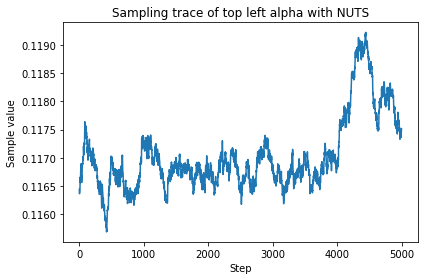

In [291]:
X = posterior_samples['concentration'][:,0,0,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

In [13]:
## Data preparation and cleaning
# importing required packages
import pyreadr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%autosave 30



Autosaving every 30 seconds


In [14]:
# import data and convert to python objects
# load Rdata object
rdata = pyreadr.read_r('tomtom_data/det_dfs.Rdata')
# pull out separate dataframes, one with choice text, the other with numeric responses
df = rdata['df']
dfn = rdata['dfn']
df.head()


# read in state labels
states = pd.read_csv('tomtom_data/states.csv')
states['statepair'] = states['state1'] + '_' + states['state2']# construct state pair strings
states.head()

# extract all the self ratings
ind_selfq1 = df.columns.get_loc('X1_Q12_1') # location of the first question
trans_self = df.iloc[:,list(range(ind_selfq1,(ind_selfq1+75)))]
print(trans_self.shape)
trans_self.columns = states['statepair'].tolist() # renaming transitioin columns with the corresponding transition pairs
print(trans_self.columns[1:5])
trans_self.head()

(94, 75)
Index(['assertive_grouchy', 'assertive_sad', 'assertive_assertive',
       'assertive_unrestrained'],
      dtype='object')


,assertive_confident,assertive_grouchy,assertive_sad,assertive_assertive,assertive_unrestrained,confident_confident,confident_grouchy,confident_sad,confident_assertive,confident_unrestrained,...,love_satisfaction,love_love,love_contempt,love_disgust,love_embarrassment,satisfaction_satisfaction,satisfaction_love,satisfaction_contempt,satisfaction_disgust,satisfaction_embarrassment
0,92,45,43,95,89,97,38,57,90,77,...,92,95,23,13,44,94,99,27,16,45
1,65,50,10,60,100,65,5,40,90,55,...,95,100,20,20,30,100,50,10,60,40
2,80,61,36,70,70,79,10,35,82,81,...,85,90,9,11,75,96,76,25,24,75
3,85,65,10,75,75,75,10,15,85,85,...,95,95,5,5,15,90,90,5,5,10
4,90,70,33,84,80,87,25,22,90,85,...,87,87,14,10,26,85,78,29,9,16


In [15]:
## preparation
# set the constant for converting probability to frequency
freq_constant = 10000
# indexing autotransition columns
colnames = trans_self.columns.tolist()
cnsplit = [p.split('_') for p in colnames]
idx_autotransition = [p[0] == p[1] for p in cnsplit] # list of boolean, True = is autotransition


# 1. normalizing with autotransitions included, one df for probability, one converted to frequency
# initialize 2 dataframes
ts_norm_all = pd.DataFrame(columns=trans_self.columns, index = trans_self.index)
ts_norm_all_f =  pd.DataFrame(columns=trans_self.columns, index = trans_self.index)

# normalize by row-sum every five columns, since the columns are already arranged by from-state in 5
for i in range(0,trans_self.shape[1],5):
    dftemp = trans_self.iloc[:,i:(i+5)]
    dftemp_rowsum = dftemp.sum(axis = 1)
    normed_cols = dftemp/dftemp_rowsum[:,np.newaxis]
    ts_norm_all.iloc[:,i:(i+5)] = normed_cols
    ts_norm_all_f.iloc[:,i:(i+5)] = (normed_cols * freq_constant).round()

# 2. two additional dataframes: normed with auto transition but don't contain them
ts_norm_all_noauto = ts_norm_all.loc[:,[not t for t in idx_autotransition]]
ts_norm_all_noauto_f = ts_norm_all_f.loc[:,[not t for t in idx_autotransition]]

# 3. finally, normalizing without autotransitions, and also convert to frequency
trans_self_noauto = trans_self.loc[:,[not t for t in idx_autotransition]]
ts_norm_noauto = pd.DataFrame(columns=trans_self_noauto.columns, index = trans_self_noauto.index)
ts_norm_noauto_f = pd.DataFrame(columns=trans_self_noauto.columns, index = trans_self_noauto.index)

# normalize by row-sum every FOUR columns, grouped by from-state in 4 without autotransition
for i in range(0,trans_self_noauto.shape[1],4):
    dftemp = trans_self_noauto.iloc[:,i:(i+4)]
    dftemp_rowsum = dftemp.sum(axis = 1)
    normed_cols = dftemp/dftemp_rowsum[:,np.newaxis]
    ts_norm_noauto.iloc[:,i:(i+5)] = normed_cols
    ts_norm_noauto_f.iloc[:,i:(i+5)] = (normed_cols * freq_constant).round()


In [16]:
ts_norm_all_3d = torch.tensor(np.stack([np.array(ts_norm_all.iloc[0]).reshape(15,5) for i in np.arange(ts_norm_all.shape[0])]).astype('float32'))

In [17]:
ts_norm_all_3d.dtype


torch.float32

In [18]:
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

def initialize(seed):           
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'concentration']))
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, ts_norm_all_3d)

loss, seed = min((initialize(seed), seed) for seed in range(100))
#initialize(100)
print('seed = {}, initial_loss = {}'.format(seed, loss))


seed = 44, initial_loss = -4241.4052734375


In [19]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(3000):
    loss = svi.step(ts_norm_all_3d)
    print(loss)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

map_estimates = global_guide(data)
concentration = map_estimates['concentration']
# print('alphas = {}'.format(alphas.data.numpy()))
# print('betas = {}'.format(betas.data.numpy()))
print('concentrations = {}'.format(concentration.data.numpy()))

-2915.283447265625

-2925.509521484375
.-2935.719970703125
.-2945.915283203125
.-2956.112548828125
.-2966.284912109375
.-2976.453857421875
.-2986.612060546875
.-2996.750244140625
.-3006.87646484375
.-3016.993408203125
.-3027.09619140625
.-3037.18603515625
.-3047.263427734375
.-3057.3291015625
.-3067.37939453125
.-3077.411865234375
.-3087.433349609375
.-3097.44287109375
.-3107.439453125
.-3117.42041015625
.-3127.384033203125
.-3137.336669921875
.-3147.285888671875
.-3157.205078125
.-3167.11962890625
.-3177.024169921875
.-3186.911865234375
.-3196.779052734375
.-3206.6435546875
.-3216.487060546875
.-3226.326904296875
.-3236.147705078125
.-3245.96337890625
.-3255.7607421875
.-3265.551025390625
.-3275.32373046875
.-3285.084228515625
.-3294.84521484375
.-3304.59326171875
.-3314.32421875
.-3324.050537109375
.-3333.761474609375
.-3343.4794921875
.-3353.17919921875
.-3362.869873046875
.-3372.56640625
.-3382.25146484375
.-3391.943603515625
.-3401.627685546875
.-3411.308837890625
.-3421.004638671

.-6881.09814453125
.-6886.85595703125
.-6892.58984375
.-6898.31787109375
.-6904.04443359375
.-6909.76611328125
.-6915.48828125
.-6921.20068359375
.-6926.89208984375
.-6932.580078125
.-6938.28173828125
.-6943.9599609375
.-6949.63720703125
.-6955.28564453125
.-6960.958984375
.-6966.60400390625
.-6972.2607421875
.-6977.89990234375
.-6983.53369140625
.-6989.16357421875
.-6994.765625
.-7000.3857421875
.-7006.0048828125
.-7011.6005859375
.-7017.18994140625
.-7022.7783203125
.-7028.3623046875
.-7033.9443359375
.-7039.498046875
.-7045.0703125
.-7050.615234375
.-7056.15771484375
.-7061.69775390625
.-7067.2373046875
.-7072.7744140625
.-7078.30224609375
.-7083.80908203125
.-7089.314453125
.-7094.8310546875
.-7100.3251953125
.-7105.8193359375
.-7111.28955078125
.-7116.7734375
.-7122.23388671875
.-7127.71337890625
.-7133.1640625
.-7138.61279296875
.-7144.060546875
.-7149.5078125
.-7154.9443359375
.-7160.359375

-7165.7939453125
.-7171.2060546875
.-7176.6103515625
.-7182.01220703125
.-7187.412597656

.-9005.810546875
.-9009.138671875
.-9012.46875
.-9015.7744140625
.-9019.0927734375
.-9022.421875
.-9025.7255859375
.-9029.0361328125
.-9032.3427734375
.-9035.63671875
.-9038.9462890625
.-9042.232421875
.-9045.51953125
.-9048.806640625
.-9052.0703125
.-9055.3525390625
.-9058.6220703125
.-9061.880859375
.-9065.158203125
.-9068.4345703125
.-9071.677734375
.-9074.92578125
.-9078.181640625
.-9081.416015625
.-9084.6630859375
.-9087.8974609375
.-9091.142578125
.-9094.3701171875
.-9097.6015625
.-9100.8203125
.-9104.0439453125
.-9107.25
.-9110.466796875
.-9113.681640625
.-9116.87890625
.-9120.080078125
.-9123.2724609375
.-9126.4677734375
.-9129.65625
.-9132.849609375
.-9136.029296875
.-9139.1962890625
.-9142.3798828125
.-9145.544921875
.-9148.7177734375
.-9151.875
.-9155.037109375
.-9158.19921875
.-9161.357421875
.-9164.4990234375
.-9167.65234375
.-9170.7744140625
.-9173.9208984375
.-9177.0595703125
.-9180.1748046875
.-9183.306640625
.-9186.4326171875
.-9189.5615234375
.-9192.6669921875
.-9195.

.-10245.1025390625
.-10247.0263671875
.-10248.955078125
.-10250.884765625
.-10252.7939453125
.-10254.7177734375
.-10256.6396484375
.-10258.564453125
.-10260.46875
.-10262.37109375
.-10264.271484375
.-10266.193359375
.-10268.09375
.-10269.9970703125
.-10271.8974609375
.-10273.794921875
.-10275.693359375
.-10277.5908203125
.-10279.4873046875
.-10281.380859375
.-10283.27734375
.-10285.1572265625
.-10287.052734375
.-10288.9453125
.-10290.83984375
.-10292.7119140625
.-10294.6025390625
.-10296.4697265625
.-10298.341796875
.-10300.2314453125
.-10302.1025390625
.-10303.9697265625
.-10305.837890625
.-10307.708984375
.-10309.5751953125
.-10311.4404296875
.-10313.30859375
.-10315.1708984375
.-10317.0380859375
.-10318.8798828125
.-10320.7431640625
.-10322.60546875
.-10324.451171875
.-10326.3134765625
.-10328.154296875
.-10330.0146484375
.-10331.8505859375
.-10333.6875
.-10335.548828125
.-10337.388671875
.-10339.2255859375
.-10341.05859375
.-10342.8955078125
.-10344.7509765625
.-10346.5703125
.-103

.-10991.6611328125
.-10993.10546875
.-10994.5244140625
.-10995.9638671875
.-10997.412109375
.-10998.8515625
.-11000.275390625
.-11001.6962890625
.-11003.1298828125
.-11004.578125
.-11006.0166015625
.-11007.4384765625
.-11008.85546875
.-11010.2939453125
.-11011.7421875
.-11013.162109375
.-11014.5771484375
.-11016.0166015625
.-11017.4384765625
.-11018.8720703125
.-11020.291015625
.-11021.73828125
.-11023.1708984375
.-11024.5908203125
.-11026.0048828125
.-11027.421875
.-11028.841796875
.-11030.279296875

-11031.693359375
.-11033.1064453125
.-11034.548828125
.-11035.9677734375
.-11037.3984375
.-11038.8125
.-11040.23046875
.-11041.646484375
.-11043.060546875
.-11044.4736328125
.-11045.8916015625
.-11047.3232421875
.-11048.71875
.-11050.1494140625
.-11051.5625
.-11052.9755859375
.-11054.392578125
.-11055.8046875
.-11057.21875
.-11058.6298828125
.-11060.037109375
.-11061.455078125
.-11062.8681640625
.-11064.2802734375
.-11065.69140625
.-11067.103515625
.-11068.515625
.-11069.9267578125
.-1107

.-11616.666015625
.-11617.966796875
.-11619.2626953125
.-11620.552734375
.-11621.8486328125
.-11623.12890625
.-11624.4404296875
.-11625.736328125
.-11627.015625
.-11628.3115234375
.-11629.6064453125
.-11630.9013671875
.-11632.197265625
.-11633.4912109375
.-11634.7861328125
.-11636.083984375
.-11637.373046875
.-11638.66796875
.-11639.962890625
.-11641.2568359375
.-11642.5517578125
.-11643.8447265625
.-11645.1396484375
.-11646.43359375
.-11647.724609375
.-11649.0224609375
.-11650.3173828125
.-11651.607421875
.-11652.90625
.-11654.1943359375
.-11655.4736328125
.-11656.767578125
.-11658.0556640625
.-11659.353515625
.-11660.6494140625
.-11661.9384765625
.-11663.2314453125
.-11664.5263671875
.-11665.787109375
.-11667.080078125
.-11668.375
.-11669.7001953125
.-11670.9619140625
.-11672.2509765625
.-11673.5439453125
.-11674.8193359375
.-11676.11328125
.-11677.40625
.-11678.69921875
.-11679.9921875
.-11681.279296875
.-11682.572265625
.-11683.865234375
.-11685.1572265625
.-11686.4482421875
.-1168

.-12209.033203125
.-12210.2978515625
.-12211.5224609375
.-12212.7900390625
.-12214.0537109375
.-12215.3193359375
.-12216.5634765625
.-12217.830078125
.-12219.095703125
.-12220.3544921875
.-12221.619140625
.-12222.880859375
.-12224.1474609375
.-12225.41015625
.-12226.6552734375
.-12227.919921875
.-12229.1796875
.-12230.4423828125
.-12231.6708984375
.-12232.9306640625
.-12234.2021484375
.-12235.4599609375
.-12236.7236328125
.-12237.97265625
.-12239.2314453125
.-12240.486328125
.-12241.751953125
.-12243.01953125
.-12244.279296875
.-12245.541015625
.-12246.7900390625
.-12248.0537109375
.-12249.3115234375
.-12250.5400390625
.-12251.8369140625
.-12253.0458984375
.-12254.3232421875
.-12255.5703125
.-12256.828125
.-12258.0966796875
.-12259.35546875
.-12260.6181640625
.-12261.8779296875
.-12263.1357421875
.-12264.376953125
.-12265.64453125
.-12266.9013671875
.-12268.1640625
.-12269.42578125
.-12270.65234375
.-12271.9150390625
.-12273.17578125
.-12274.41796875
.-12275.6953125
.-12276.9404296875


In [20]:
map_estimates['weights']

tensor([0.0634, 0.9366], grad_fn=<ExpandBackward>)

In [21]:
# i think(?) this is needed to set random seed for pyro fns
pyro.set_rng_seed(19931007)

from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=5000, warmup_steps=1000)
mcmc.run(ts_norm_all_3d)

#hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|█████████████████████████████████████| 6000/6000 [1:35:59,  1.04it/s, step size=6.47e-02, acc. prob=0.855]


In [30]:
posterior_samples = mcmc.get_samples()
posterior_samples['weights'].shape

torch.Size([5000, 2])

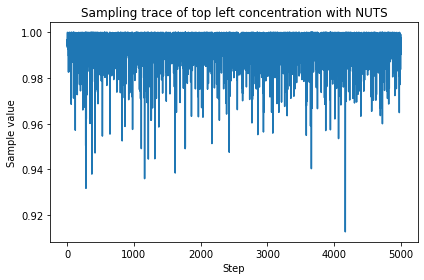

In [31]:
#X = posterior_samples['concentration'][:,0,0,0]
X = posterior_samples['weights'][:,0]

#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left concentration with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

In [ ]:
# generate predictions and compare againts real data (posterior predictive check)

In [ ]:
# umap visualization

In [ ]:
# different normalization and autotransition stuff